# Labeling the news with the dollar variation

Now we ave to label each news with the respective dollar variation

## Importing the libraries and loading the FastText model

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras

from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

from gensim.models import KeyedVectors

word_vec_model = KeyedVectors.load_word2vec_format('../datasets/word-vectors/wiki.pt/wiki.pt.vec')

word_vec_model

import matplotlib.pyplot as plt 

Using TensorFlow backend.


## Importing and indexing the dollar dataframe

In [2]:
dolar_rates_df = pd.read_csv('../datasets/pre-processed/dolar_rates.csv')

dolar_rates_df = dolar_rates_df.set_index("quote_timestamp")

dolar_rates_df.tail(5)

variation
quote_timestamp                  
2019-08-29 10:09:17.705        up
2019-08-29 11:10:17.541        up
2019-08-29 12:11:17.181      down
2019-08-29 13:09:45.961      down
2019-08-29 13:09:45.964        up

## Importing and indexing the news dataframe

In [3]:
news_df = pd.read_csv('../datasets/pre-processed/news.csv')
news_df = news_df.set_index("date_published")

news_df.head(5)

text
date_published                                                        
2019-05-28 22:40:00  bolsonaro diz ter mais poder que maia por ter ...
2019-05-28 12:46:00  por corte menor, sistema s promete a bolsonaro...
2019-05-28 11:16:00  major olímpio sobre moro: "não dá para defende...
2019-05-28 02:00:00  doria é stalinista ao dizer que quem não conco...
2019-05-28 10:24:00  planalto, congresso e stf combinam assinar pac...

## Reindexing the dollar dataframe by the nearest news timestamp

In [4]:
dolar_rates_df = dolar_rates_df.reindex(news_df.index, method='backfill')

dolar_rates_df = dolar_rates_df.loc[~dolar_rates_df.index.duplicated(keep='first')]

dolar_rates_df.head(10)

variation
date_published               
2019-05-28 22:40:00      down
2019-05-28 12:46:00        up
2019-05-28 11:16:00      down
2019-05-28 02:00:00        up
2019-05-28 10:24:00      down
2019-05-28 10:59:00      down
2019-05-28 09:15:00        up
2019-05-28 13:17:00      down
2019-05-28 13:46:00      down
2019-05-28 14:41:00      down

## Joining the two dataframes by their indexes

In [5]:
news_df = news_df.join(dolar_rates_df)
news_df = news_df.reset_index()
news_df = news_df.drop(['date_published'], axis=1)
news_df = news_df.dropna(subset=['variation'])

news_df = news_df[news_df.variation != 'steady']

news_df.head(5)

text variation
3      candidato do prtb em sp defende máquina menor      down
4  distanciamento de alckmin em são paulo esfria ...      down
5  bank of america projeta dólar em r$ 5,50 depoi...      down
6  indústria apresenta proposta de reforma tribut...        up
7  meirelles não pode ter vergonha de temer, afir...        up

# Tokenizing the text

Transforming all the news texts into sequences of numbers

## Extracting the text from the dataframe

In [6]:
news_text = news_df.drop(['variation'], axis = 1).to_numpy()
news_text = np.squeeze(np.asarray(news_text))
news_text

array(['candidato do prtb em sp defende máquina menor',
       'distanciamento de alckmin em são paulo esfria sua relação com márcio frança',
       'bank of america projeta dólar em r$ 5,50 depois das eleições',
       ...,
       'senado aprova redução de ministérios e coaf sem moro após apelo de bolsonaro',
       'bolsonaro diz ter mais poder que maia por ter "caneta para editar decretos"',
       'veja quais senadores votaram para que o coaf ficasse com moro na justiça'],
      dtype=object)

## Transforming the text into an array of word vector means

In [7]:
means_array = []
for sentence in news_text:
    word_vectors_array = []
    for word in text_to_word_sequence(sentence):
        if word in word_vec_model.vocab:
            word_vectors_array.append(word_vec_model[word])
    mean = np.mean(word_vectors_array, axis=0)
    means_array.append(mean)

means_array


#tokenizer.fit_on_texts(news_text)

#sequences = tokenizer.texts_to_sequences(news_text)

#sequences

[array([-1.81965083e-02,  1.13066249e-01,  2.16624234e-03, -1.23889379e-01,
         1.89267874e-01,  1.11774117e-01,  1.05808161e-01, -6.96410015e-02,
         8.84320065e-02, -1.63301989e-01,  1.77787140e-01,  1.01277314e-01,
         2.66205370e-02,  1.13768496e-01,  6.30155057e-02, -1.33747552e-02,
         9.63096246e-02, -3.60282511e-01, -8.94528776e-02, -2.62618244e-01,
         8.27951282e-02, -1.98099762e-01, -8.75253752e-02,  4.48038802e-02,
         2.83971757e-01, -1.23506367e-01,  3.63948345e-02, -1.34445995e-01,
         7.94983730e-02, -1.13588879e-02,  6.77590072e-02, -7.80350119e-02,
        -2.11512923e-01,  5.23872487e-02, -5.34653664e-02, -1.05304241e-01,
         1.45267501e-01, -5.61917536e-02, -1.20619640e-01, -3.91937494e-02,
         6.49697483e-02,  1.56337515e-01,  1.14103749e-01, -8.42448771e-02,
        -1.18762881e-01,  1.50586486e-01,  1.77557990e-01,  2.33826265e-02,
        -7.73426369e-02, -3.39384764e-01, -1.39440626e-01,  1.25863373e-01,
         6.8

# Extracting the labels

In [8]:
news_df['variation'] = news_df['variation'].apply(lambda variation: int(1) if variation == 'up' else int(0))


labels = news_df[['variation']].to_numpy()

labels

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

# Plotting the classes distribution accross the dataset

(array([2089.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2172.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

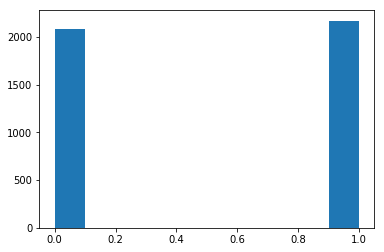

In [9]:
plt.hist(labels)

In [10]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 2089, 1: 2172}

# Saving the final datasets into files

In [11]:
np.savetxt("../datasets/final-data/features.csv", means_array, delimiter=",")
np.savetxt("../datasets/final-data/labels.csv", labels, delimiter=",")